## 자전거 대여 수요 예측
### 경진대회 이해
- https://www.kaggle.com/competitions/bike-sharing-demand
- 경진대회명 : Bike Sharing Demand (자전거 대여 수요 예측)
- 미션 : 날짜, 계절, 근무일 여부, 날씨, 온도, 체감 온도, 풍속 데이터를 활용하여 자전거 대여 수량 예측
- 문제 유형 : 회귀
- 평가지표 : RMSLE

#### 6.3 탐색적 데이터 분석

##### 6.3.2 데이터 둘러보기
- datetime - hourly date + timestamp  (1시간 간격)
- season 
    - 1 = spring
    - 2 = summer
    - 3 = fall
    - 4 = winter 
- holiday - whether the day is considered a holiday (0: 공휴일x, 1: 공휴일)
- workingday - whether the day is neither a weekend nor holiday (0: 근무일x, 1: 근무일)
- weather
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy (맑음)
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist (옅은 안개, 약간 흐림)
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds (약간의 눈, 약간의 비)
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog (폭우, 천둥 번개)
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated (비회원 수)
- registered - number of registered user rentals initiated (회원 수)
- count - number of total rentals

In [111]:
import numpy as np
import pandas as pd

data_path = 'C:/Users/hyebin.hyebin/Desktop/python/kaggle_dataset/bike-sharing-demand/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

In [112]:
train.shape, test.shape

((10886, 12), (6493, 9))

In [113]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [114]:
test.head() # 테스트 데이터에는 casual, registered 피처 없음 -> 모델 훈련 시에도 두 피처는 제외해야함

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [115]:
submission.head() # datetime은 ID역할만 하고, 타깃값을 예측하는 데에는 도움x, 모델 훈련 시 해당 피처 제거

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [116]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [117]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


##### 6.3.3 더 효과적인 분석을 위한 피처 엔지니어링
- 시각화하기에 적합하지 않은 형태의 데이터를 변환

In [118]:
# datetime 확인
print(train['datetime'][100])
print(train['datetime'][100].split())
print(train['datetime'][100].split()[0]) # 일자
print(train['datetime'][100].split()[1]) # 시간

2011-01-05 09:00:00
['2011-01-05', '09:00:00']
2011-01-05
09:00:00


In [119]:
print(train['datetime'][100].split()[0]) # 일자
print(train['datetime'][100].split()[0].split('-')) 
print(train['datetime'][100].split()[0].split('-')[0]) # 연도
print(train['datetime'][100].split()[0].split('-')[1]) # 월
print(train['datetime'][100].split()[0].split('-')[2]) # 일

2011-01-05
['2011', '01', '05']
2011
01
05


In [120]:
print(train['datetime'][100].split()[1]) # 시간
print(train['datetime'][100].split()[1].split(':')) 
print(train['datetime'][100].split()[1].split(':')[0]) # 시간
print(train['datetime'][100].split()[1].split(':')[1]) # 분
print(train['datetime'][100].split()[1].split(':')[2]) # 초

09:00:00
['09', '00', '00']
09
00
00


In [121]:
# 파생 피처, 파생 변수 생성

train['date'] = train['datetime'].apply(lambda x: x.split()[0]) # 일자

train['year'] = train['datetime'].apply(lambda x: x.split()[0].split('-')[0]) # 연도
train['month'] = train['datetime'].apply(lambda x: x.split()[0].split('-')[1]) # 월
train['day'] = train['datetime'].apply(lambda x: x.split()[0].split('-')[2]) # 일

train['hour'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[0]) # 시간
train['minute'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[1]) # 분
train['second'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[2]) # 초

In [122]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,00,00
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,01,01,02,00,00
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,01,01,03,00,00
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,01,01,04,00,00


In [123]:
from datetime import datetime
import calendar

print(train['date'][100]) # 일자
print(datetime.strptime(train['date'][100], '%Y-%m-%d')) # datetime 타입으로 변경

# 정수로 요일 반환. 0: 월, 1: 화, 2: 수, ...
print(datetime.strptime(train['date'][100], '%Y-%m-%d').weekday()) 

# 문자열로 요일 반환
print(calendar.day_name[datetime.strptime(train['date'][100], '%Y-%m-%d').weekday()]) 

2011-01-05
2011-01-05 00:00:00
2
Wednesday


In [124]:
train['weekday'] = train['date'].apply(lambda dateString: calendar.day_name[datetime.strptime(dateString, '%Y-%m-%d').weekday()])

In [125]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00,Saturday
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,00,00,Saturday
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,01,01,02,00,00,Saturday
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,01,01,03,00,00,Saturday
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,01,01,04,00,00,Saturday


In [126]:
train['season'] = train['season'].map({1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'})
train['weather'] = train['weather'].map({1: 'Clear', 2: 'Mist, Few clouds', 3: 'Light Snow, Rain', 4: 'Heavy Rain, Snow, Fog'})

In [127]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00,Saturday
1,2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,00,00,Saturday
2,2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,01,01,02,00,00,Saturday
3,2011-01-01 03:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,01,01,03,00,00,Saturday
4,2011-01-01 04:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,01,01,04,00,00,Saturday


#### 6.3.4 데이터 시각화

In [128]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline # matplotlib이 그린 그래프를 주피터 노트북에서 바로 출력

UsageError: unrecognized arguments: # matplotlib이 그린 그래프를 주피터 노트북에서 바로 출력


##### 1) 분포도

c:\Users\hyebin.hyebin\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


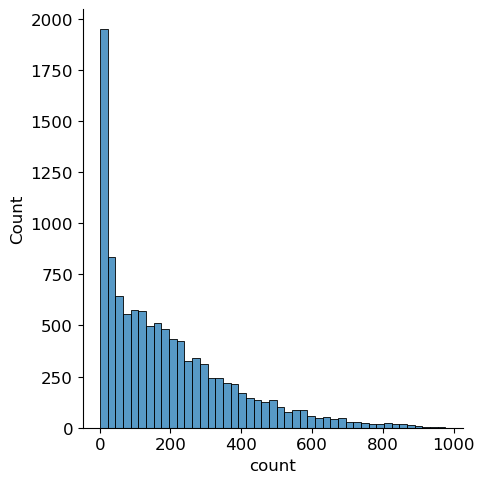

In [129]:
mpl.rc('font', size = 12)
sns.displot(train['count']) 
# 0 근처에 몰려있어 분포가 왼쪽으로 많이 편향되어 있음
# 회귀 모델이 좋은 성능을 내기 위해서는 타깃값이 정규분포를 따라야 함
# -> 타깃값을 로그변환

c:\Users\hyebin.hyebin\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


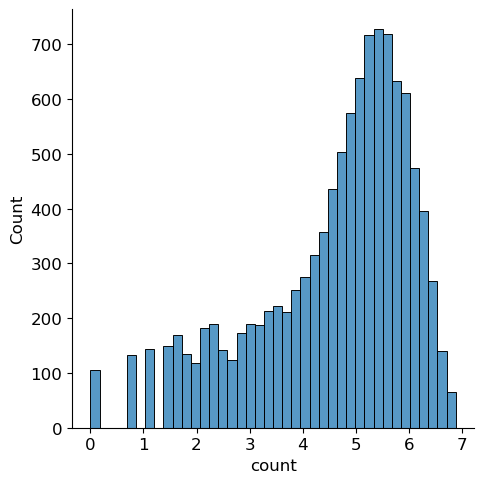

In [130]:
sns.displot(np.log(train['count']))

##### 2) 막대 그래프

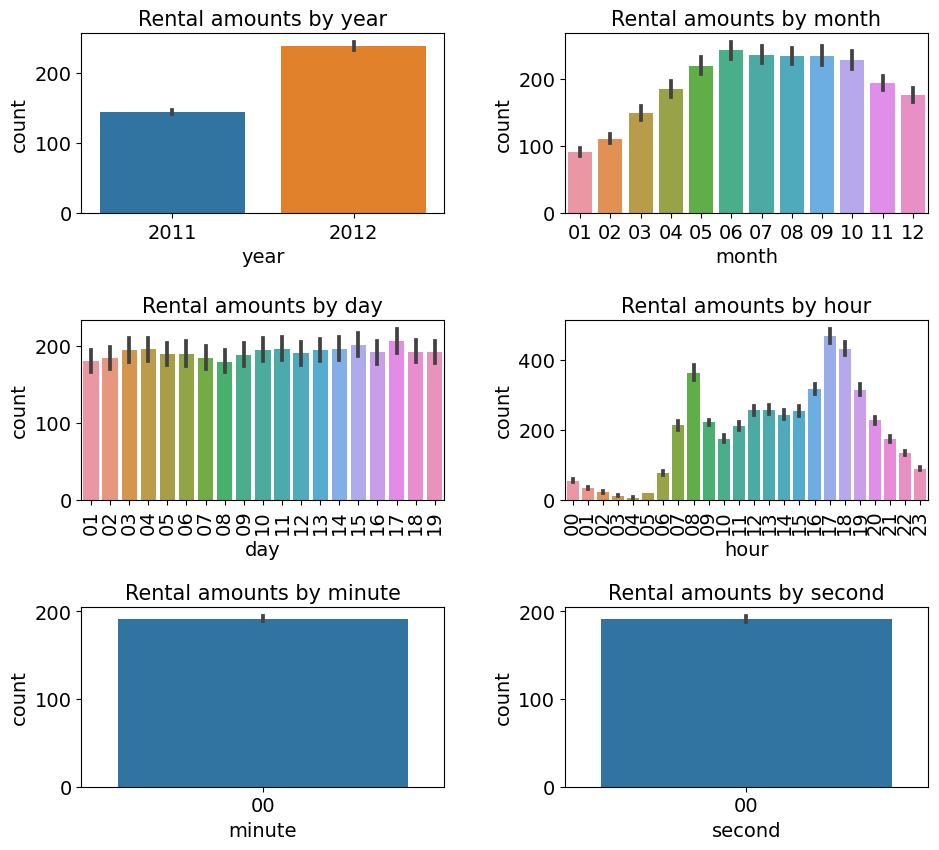

In [131]:
# mxn figure 준비
mpl.rc('font', size = 14)
mpl.rc('axes', titlesize = 15)

figure, axes = plt.subplots(nrows = 3, ncols = 2) # 3x2 figure 생성
plt.tight_layout() # 그래프 사이 여백 확보
figure.set_size_inches(10, 9) # 전체 figure 크기 10x9인치로 설정


# 각 축에 서브플롯 할당
sns.barplot(x = 'year', y = 'count', data = train, ax = axes[0, 0])
sns.barplot(x = 'month', y = 'count', data = train, ax = axes[0, 1])
sns.barplot(x = 'day', y = 'count', data = train, ax = axes[1, 0])
sns.barplot(x = 'hour', y = 'count', data = train, ax = axes[1, 1])
sns.barplot(x = 'minute', y = 'count', data = train, ax = axes[2, 0])
sns.barplot(x = 'second', y = 'count', data = train, ax = axes[2, 1])

# 세부설정
axes[0, 0].set(title = 'Rental amounts by year')
axes[0, 1].set(title = 'Rental amounts by month')
axes[1, 0].set(title = 'Rental amounts by day')
axes[1, 1].set(title = 'Rental amounts by hour')
axes[2, 0].set(title = 'Rental amounts by minute')
axes[2, 1].set(title = 'Rental amounts by second')

# x축 라벨들을 90도 회전
axes[1, 0].tick_params(axis = 'x', labelrotation = 90) 
axes[1, 1].tick_params(axis = 'x', labelrotation = 90) 

- year : 2011년 보다 2012년에 대여 수가 더 많음
- month : 6월에 가장 대여 수가 많고, 겨울에는 적음
- day : 데이터가 19일까지 밖에 없고, 일 별 차이가 크지 않음 -> 피처 제거
- hour : 출근시간, 퇴근시간에 대여 수가 많음 
- minute, second : 모두 0으로 기록. 피처에서 제거

##### 3) 박스플롯

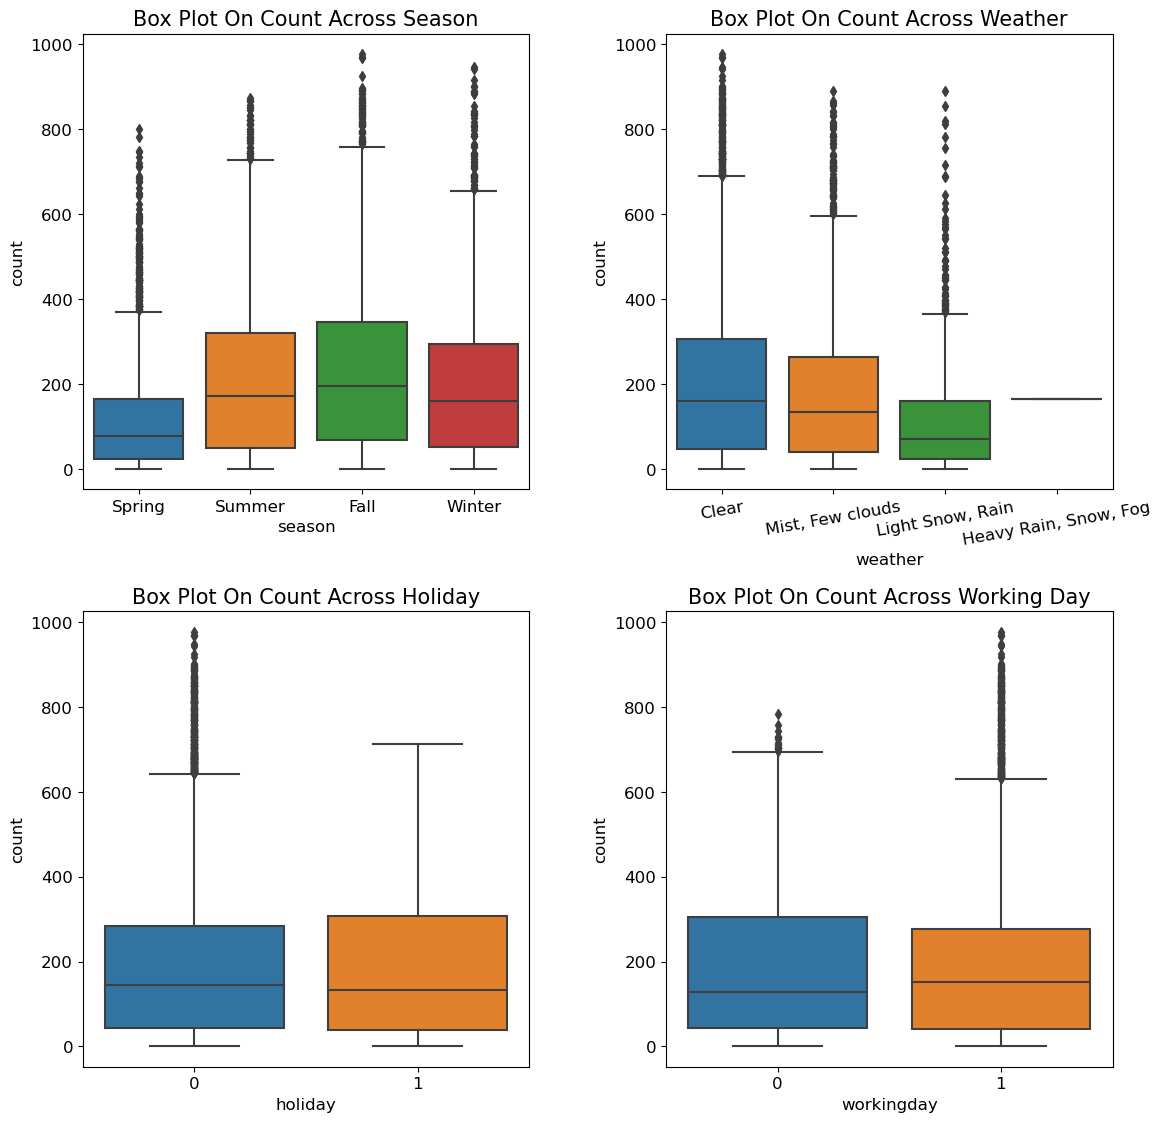

In [132]:
mpl.rc('font', size = 12)
mpl.rc('axes', titlesize = 15)

figure, axes = plt.subplots(nrows = 2, ncols = 2)
plt.tight_layout()
figure.set_size_inches(12, 12)

sns.boxplot(x = 'season', y = 'count', data = train, ax = axes[0, 0])
sns.boxplot(x = 'weather', y = 'count', data = train, ax = axes[0, 1])
sns.boxplot(x = 'holiday', y = 'count', data = train, ax = axes[1, 0])
sns.boxplot(x = 'workingday', y = 'count', data = train, ax = axes[1, 1])

axes[0, 0].set(title = 'Box Plot On Count Across Season')
axes[0, 1].set(title = 'Box Plot On Count Across Weather')
axes[1, 0].set(title = 'Box Plot On Count Across Holiday')
axes[1, 1].set(title = 'Box Plot On Count Across Working Day')

axes[0, 1].tick_params(axis = 'x', labelrotation = 10)

- season : 봄에 가장 적고, 가을에 가장 많음
- weather : 날씨가 좋을 수록 (x 값이 왼쪽으로 갈 수록) 대여 수가 많음
- holiday : 공휴일과 공휴일이 아닌 날의 중앙값은 비슷하나, 공휴일이 아닌 날의 이상치가 더 많음
- workingday : 근무일과 근무일이 아닌 날의 중앙값은 비슷하나, 근무일인 날의 이상치가 더 많음

##### 4) 포인트플롯

<Axes: xlabel='hour', ylabel='count'>

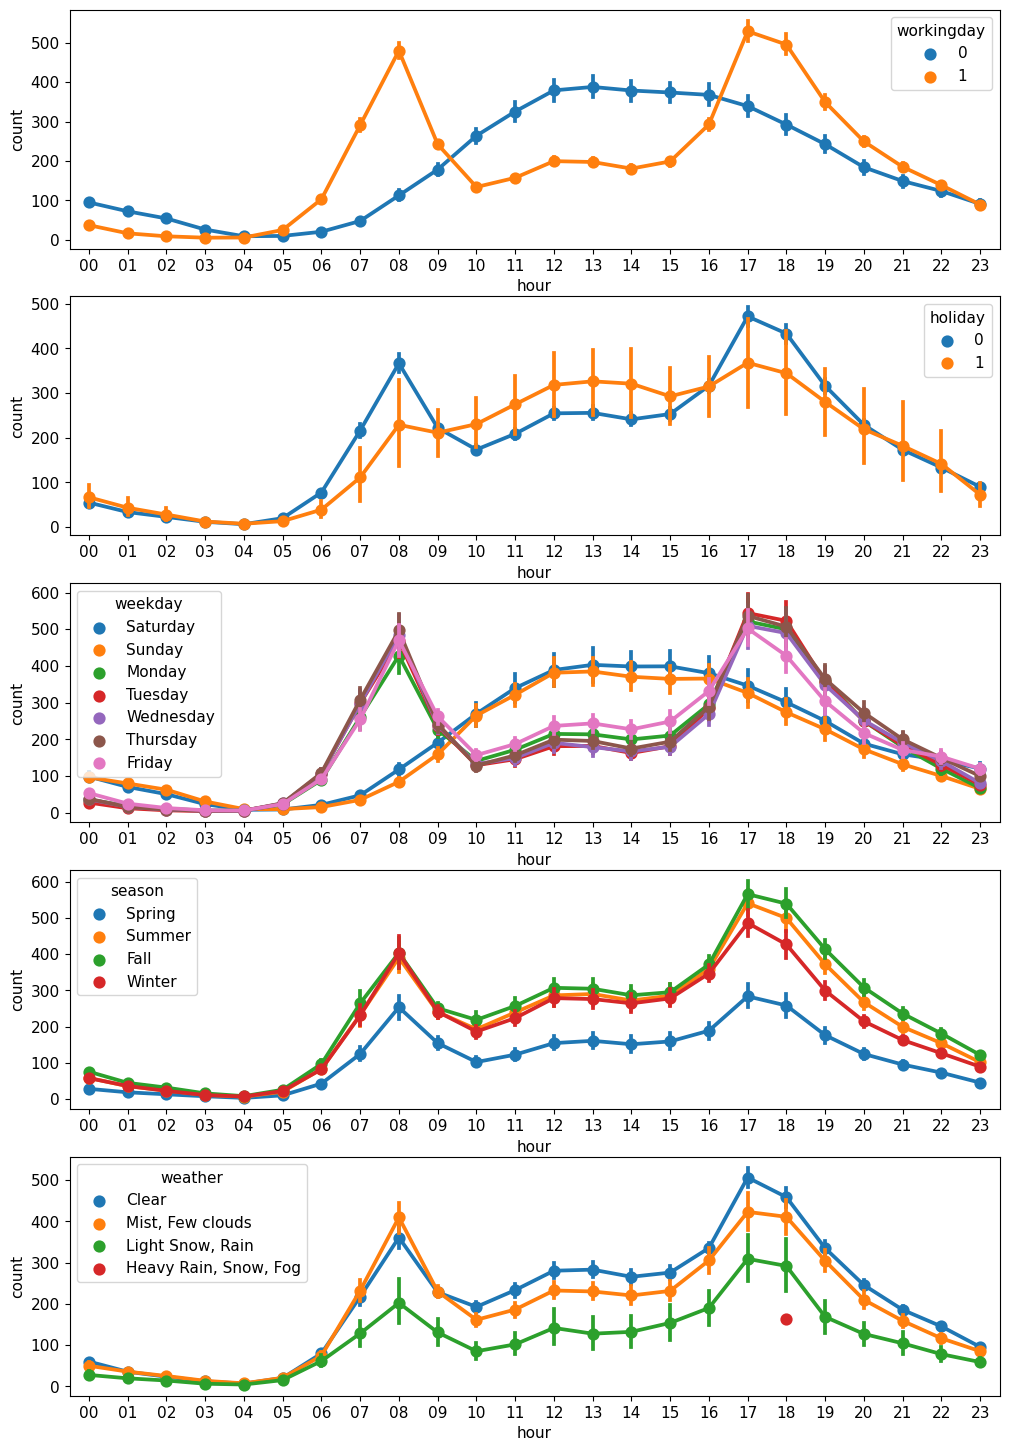

In [133]:
mpl.rc('font', size = 11)
figure, axes = plt.subplots(nrows = 5, ncols = 1)
figure.set_size_inches(12, 18)

sns.pointplot(x = 'hour', y = 'count', data = train, hue = 'workingday', ax = axes[0])
sns.pointplot(x = 'hour', y = 'count', data = train, hue = 'holiday', ax = axes[1])
sns.pointplot(x = 'hour', y = 'count', data = train, hue = 'weekday', ax = axes[2])
sns.pointplot(x = 'hour', y = 'count', data = train, hue = 'season', ax = axes[3])
sns.pointplot(x = 'hour', y = 'count', data = train, hue = 'weather', ax = axes[4])



- workingday : 근무일에는 출퇴근 시간에 대여 수가 가장 많고, 근무일이 아닌 날에는 12~14시에 대여 수가 가장 많음
- holiday, weekday도 workingday와 유사
- season : 가을에 대여 수가 가장 많고, 봄에 대여 수가 가장 적음
- weather : 날씨가 가장 안 좋은(4) 데이터가 18시에 발생 -> 이상치 제거 고려

##### 5) 회귀선을 포함한 산점도 그래프

<Axes: xlabel='humidity', ylabel='count'>

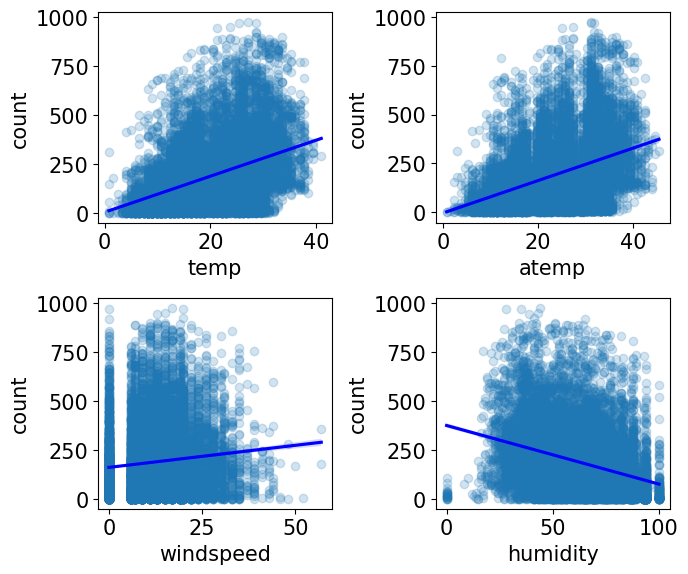

In [134]:
mpl.rc('font', size = 15)
figure, axes = plt.subplots(nrows = 2, ncols = 2)
plt.tight_layout()
figure.set_size_inches(7, 6)

sns.regplot(x = 'temp', y = 'count', data = train, ax = axes[0, 0], scatter_kws = {'alpha' : 0.2}, line_kws = {'color' : 'blue'}) # alpha : 점의 투명도 조절
sns.regplot(x = 'atemp', y = 'count', data = train, ax = axes[0, 1], scatter_kws = {'alpha' : 0.2}, line_kws = {'color' : 'blue'})
sns.regplot(x = 'windspeed', y = 'count', data = train, ax = axes[1, 0], scatter_kws = {'alpha' : 0.2}, line_kws = {'color' : 'blue'})
sns.regplot(x = 'humidity', y = 'count', data = train, ax = axes[1, 1], scatter_kws = {'alpha' : 0.2}, line_kws = {'color' : 'blue'})

- temp, atemp : 온도가 높을수록 대여 수 많음
- windspeed 
    - 풍속이 강할수록 대여 수가 많은 것처럼 보임
    - 결측치가 많아서 그런 것으로 고려됨. 
    - 풍속이 0인 데이터가 있는 것으로 보이는데, 이는 관측치가 없거나 오류를 0으로 기록한 것으로 보임
    - -> 해당 피처 제거 고려
- humidity : 습도가 낮을수록 대여 수 많음

##### 6) 히트맵

In [135]:
train[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()

,temp,atemp,humidity,windspeed,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,0.394454,0.389784,-0.317371,0.101369,1.000000


[Text(0.5, 1.0, 'Heatmap of Numerical Data')]

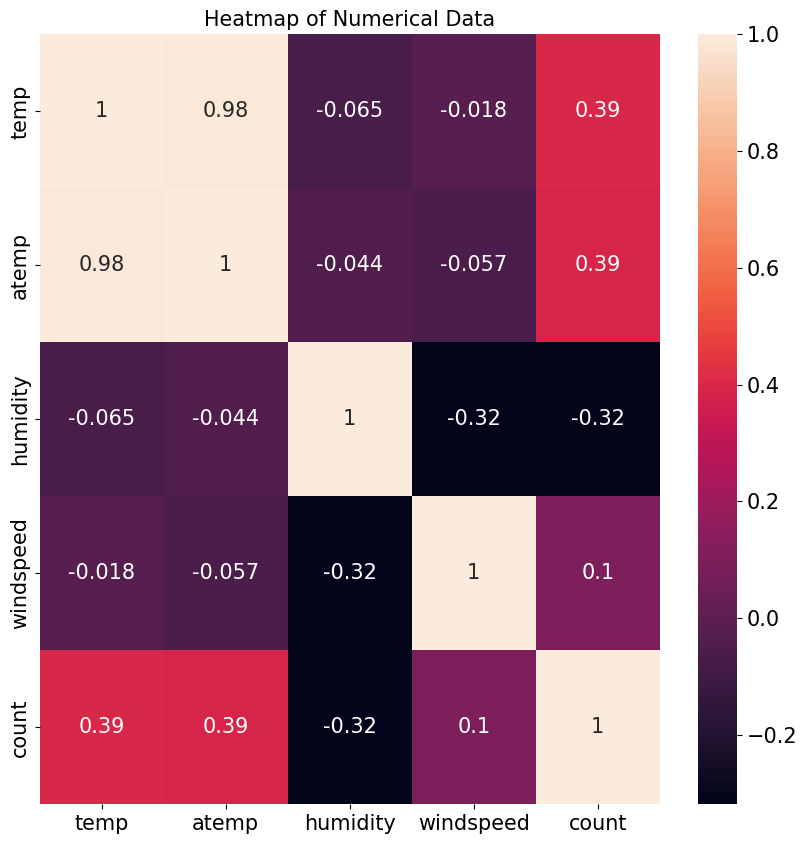

In [136]:
corrMat = train[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

sns.heatmap(corrMat, annot = True)
ax.set(title = 'Heatmap of Numerical Data')

- 온도(temp)가 높을수록 대여수량이 많음
- 습도(numidity)는 낮을수록 대여수량이 많음
- 풍속(windspeed)은 대여수량과 상관관계가 0.1로 낮음 -> 피처 제외

### 6.4 베이스라인 모델

In [169]:
import pandas as pd

data_path = 'C:/Users/hyebin.hyebin/Desktop/python/kaggle_dataset/bike-sharing-demand/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')


#### 6.4.1 피처 엔지니어링
- 데이터를 변환하는 작업
- 훈련 데이터와 테스트 데이터에 공통으로 반영해야 하기 때문에 데이터를 합쳤다가 끝나면 나눠줌

이상치 제거

In [170]:
train = train[train['weather'] != 4]

데이터 합치기

In [171]:
all_data_temp = pd.concat([train, test])
all_data_temp

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


In [172]:
all_data = pd.concat([train, test], ignore_index = True) # 인덱스 무시
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


##### 파생 피처(변수) 추가

In [173]:
from datetime import datetime

all_data['date'] = all_data['datetime'].apply(lambda x: x.split()[0])
all_data['year'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[0])
all_data['month'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[1])
all_data['hour'] = all_data['datetime'].apply(lambda x: x.split()[1].split(':')[0])
all_data['weekday'] = all_data['date'].apply(lambda dateString: datetime.strptime(dateString, '%Y-%m-%d').weekday())

In [174]:
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0,2011-01-01,2011,01,00,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0,2011-01-01,2011,01,01,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0,2011-01-01,2011,01,02,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0,2011-01-01,2011,01,03,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0,2011-01-01,2011,01,04,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN,2012-12-31,2012,12,19,0
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN,2012-12-31,2012,12,20,0
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN,2012-12-31,2012,12,21,0
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN,2012-12-31,2012,12,22,0


##### 필요 없는 피처 제거
- casual, registered 피처는 테스트 데이터에 없으므로 제거
- datetime, date 피처는 year, month, hour, weekday 피처로 대체가능하므로 제거
- month 피처도 season 피처로 대체가능하므로 제거
- windspeed 피처도 타깃값과 상관관계가 약해 제거

In [175]:
drop_features = ['casual', 'registered', 'datetime', 'date', 'month', 'windspeed']

all_data = all_data.drop(drop_features, axis = 1)

In [176]:
all_data

,season,holiday,workingday,weather,temp,atemp,humidity,count,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,16.0,2011,00,5
1,1,0,0,1,9.02,13.635,80,40.0,2011,01,5
2,1,0,0,1,9.02,13.635,80,32.0,2011,02,5
3,1,0,0,1,9.84,14.395,75,13.0,2011,03,5
4,1,0,0,1,9.84,14.395,75,1.0,2011,04,5
...,...,...,...,...,...,...,...,...,...,...,...
17373,1,0,1,2,10.66,12.880,60,NaN,2012,19,0
17374,1,0,1,2,10.66,12.880,60,NaN,2012,20,0
17375,1,0,1,1,10.66,12.880,60,NaN,2012,21,0
17376,1,0,1,1,10.66,13.635,56,NaN,2012,22,0


##### 데이터 나누기

In [177]:
# 훈련 데이터와 테스트 데이터 나누기
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

# 타깃값인 count 제거
X_train = X_train.drop(['count'], axis = 1)
X_test = X_test.drop(['count'], axis = 1)

y = train['count']

In [178]:
X_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,2011,00,5
1,1,0,0,1,9.02,13.635,80,2011,01,5
2,1,0,0,1,9.02,13.635,80,2011,02,5
3,1,0,0,1,9.84,14.395,75,2011,03,5
4,1,0,0,1,9.84,14.395,75,2011,04,5


#### 6.4.2 평가지표 계산 함수 작성

In [179]:
import numpy as np

def rmlse(y_true, y_pred, convertExp = True):
    # 지수 변환
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)

    # 로그 변환 후 결측값을 0으로 변환
    log_true = np.nan_to_num(np.log(y_true + 1))
    log_pred = np.nan_to_num(np.log(y_pred + 1))

    # RMLSE 계산
    return np.sqrt(np.mean((log_true - log_pred) ** 2)) 

#### 6.4.3 모델 훈련

In [180]:
from sklearn.linear_model import LinearRegression

linear_reg_model = LinearRegression()

In [181]:
log_y = np.log(y)
linear_reg_model.fit(X_train, log_y)

LinearRegression()

#### 6.4.4 모델 성능 검증

In [188]:
preds = linear_reg_model.predict(X_train)

In [189]:
print(f'선형 회귀의 RMSLE 값 : {rmlse(log_y, preds, True):.4f}')

선형 회귀의 RMSLE 값 : 1.0205


#### 6.4.5 예측 및 결과 제출
- 테스트 데이터로 예측한 결과를 이용해야 함
- 예측한 값에 지수변환을 해줘야 함

In [190]:
linearreg_preds = linear_reg_model.predict(X_test)

submission['count'] = np.exp(linearreg_preds)
submission.to_csv('C:/Users/hyebin.hyebin/Desktop/python/kaggle_dataset/bike-sharing-demand/submission.csv', index = False)

### 6.5 성능 개선 1 릿지 회귀 모델
- L2 규제를 적용한 선형 회귀 모델
    - 규제(regularization) : 모델이 훈련 데이터에 과대적합되지 않도록 해주는 방법
    - 성능이 좋은 편은 아니라 잘 쓰지 않음

#### 6.5.1 하이퍼파라미터 최적화(모델 훈련)
- 그리드서치(grid search) 기법 사용

##### 모델 생성

In [191]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

ridge_model = Ridge()

##### 그리드서치 객체 생성

그리드서치 객체는 아래 3개를 알고 있어야 함
- 비교 검증해볼 하이퍼파라미터 값 목록
- 대상 모델
- 교차 검증용 평가 수단(평가 함수) 

In [192]:
# 하이퍼파라미터 값 목록
ridge_params = {'max_iter': [3000], 'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}

# 교차 검증용 평가 함수(RMSLE 점수 계산)
rmsle_scorer = metrics.make_scorer(rmlse, greater_is_better = False)

# 그리드서치(with 릿지) 객체 생성
gridsearch_ridge_model = GridSearchCV(estimator = ridge_model, param_grid = ridge_params, scoring = rmsle_scorer, cv = 5) # 교차 검증 분할 수

##### 그리드서치 수행

In [193]:
log_y = np.log(y)
gridsearch_ridge_model.fit(X_train, log_y)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400,
                                   800, 900, 1000],
                         'max_iter': [3000]},
             scoring=make_scorer(rmlse, greater_is_better=False))

In [194]:
print('최적 하이퍼파라미터: ', gridsearch_ridge_model.best_params_)

최적 하이퍼파라미터:  {'alpha': 0.1, 'max_iter': 3000}


일반 선형 회귀 모델과 결과 유사 -> 성능 개선 X

#### 6.5.2 성능 검증

In [196]:
preds = gridsearch_ridge_model.best_estimator_.predict(X_train)
print(f'릿지 회귀 RMSLE 값 : {rmlse(log_y, preds, True):.4f}')

릿지 회귀 RMSLE 값 : 1.0205


### 6.6 성능 개선 2 라쏘 회귀 모델
- L1 규제를 적용한 선형 회귀 모델
- 릿지 회귀 모델과 마찬가지로 성능이 좋은 편은 아니라 잘 사용하지 않음

#### 6.6.1 하이퍼파라미터 최적화(모델 훈련)

In [197]:
from sklearn.linear_model import Lasso

# 모델 생성
lasso_model = Lasso()

# 하이퍼파라미터 값 목록
lasso_alpha = 1/np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params = {'max_iter': [3000], 'alpha': lasso_alpha}

# 그리드서치(with 라쏘) 객체 생성
gridsearch_lasso_model = GridSearchCV(estimator = lasso_model, param_grid = lasso_params, scoring = rmsle_scorer, cv = 5)

# 그리드서치 수행
log_y = np.log(y)
gridsearch_lasso_model.fit(X_train, log_y)

print('최적 하이퍼파라미터 : ', gridsearch_lasso_model.best_params_)

최적 하이퍼파라미터 :  {'alpha': 0.00125, 'max_iter': 3000}


#### 6.6.2 성능 검증

In [198]:
preds = gridsearch_lasso_model.best_estimator_.predict(X_train)

print(f'라쏘 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

라쏘 회귀 RMSLE 값 : 1.0205


일반 선형 회귀 모델과 결과 유사 -> 성능 개선 X

### 6.7 성능 개선 3 랜덤 포레스트 회귀 모델
- 훈련 데이터를 랜덤하게 샘플링한 모델 n개를 각각 훈련하여 결과를 평균하는 방법

#### 6.7.1 하이퍼파라미터 최적화(모델 훈련)

In [199]:
from sklearn.ensemble import RandomForestRegressor

randomforest_model = RandomForestRegressor()

rf_params = {'random_state': [42], 'n_estimators': [100, 120, 140]}
gridsearch_random_forest_model = GridSearchCV(estimator = randomforest_model, param_grid = rf_params, scoring = rmsle_scorer, cv = 5)

log_y = np.log(y)
gridsearch_random_forest_model.fit(X_train, log_y)
print('최적 하이퍼파라미터 : ', gridsearch_random_forest_model.best_params_)

최적 하이퍼파라미터 :  {'n_estimators': 140, 'random_state': 42}


#### 6.7.2 모델 성능 검증

In [200]:
preds = gridsearch_random_forest_model.best_estimator_.predict(X_train)

print(f'랜던 포레스트 회귀 RMSLE 값 : {rmlse(log_y, preds, True):.4f}')

랜던 포레스트 회귀 RMSLE 값 : 0.1127


앞선 3개의 모델보다 성능이 확연하게 개선됨을 확인할 수 있음

#### 6.7.3 예측 및 결과 제출

Text(0.5, 1.0, 'Predicted Test Data Distribution')

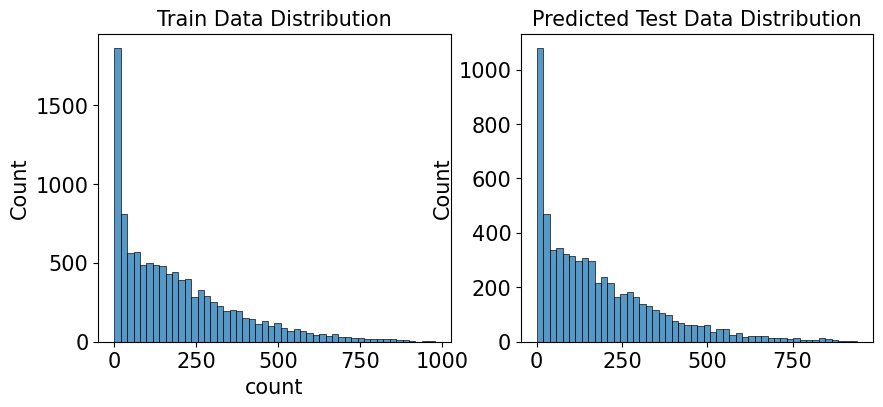

In [201]:
import seaborn as sns
import matplotlib.pyplot as plt

randomforest_preds = gridsearch_random_forest_model.best_estimator_.predict(X_test)

figure, axes = plt.subplots(ncols = 2)
figure.set_size_inches(10, 4)

sns.histplot(y, bins = 50, ax = axes[0])
axes[0].set_title('Train Data Distribution')

sns.histplot(np.exp(randomforest_preds), bins = 50, ax = axes[1])
axes[1].set_title('Predicted Test Data Distribution')

In [204]:
submission['count'] = np.exp(randomforest_preds)
submission.to_csv('C:/Users/hyebin.hyebin/Desktop/python/kaggle_dataset/bike-sharing-demand/submission.csv', index = False)